In [1]:
import numpy as np
import pandas as pd 

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2
import os

import seaborn as sns

Defining constants and getting all datas froim the dataset

In [2]:

# Define constants
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

# Function to get data from directory
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                if img_arr is not None:  # Ensure the image is read correctly
                    resized_arr = cv2.resize(img_arr, (img_size, img_size))
                    data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

# Load data
train = get_data('../../chest_xray/train')
test = get_data('../../chest_xray/test')
val = get_data('../../chest_xray/val')

In [13]:
# Separate features and labels
x_train, y_train = [], []
x_val, y_val = [], []
x_test, y_test = [], []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [4]:
# Normalize the data
x_train = np.array(x_train) / 255.0
x_val = np.array(x_val) / 255.0
x_test = np.array(x_test) / 255.0

# Reshape data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

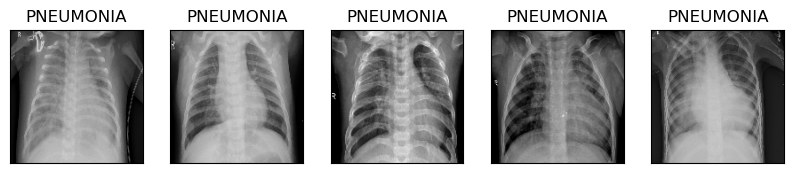

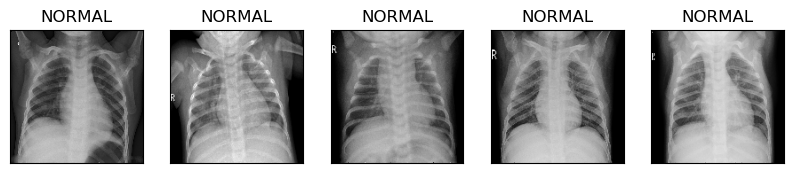

In [5]:
# Show first five and last five images
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train[i][0], cmap='gray')
    plt.title(labels[train[i][1]])
plt.show()

plt.figure(figsize=(10,10))
for i in range(1,6):
    plt.subplot(5,5,i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train[-i][0], cmap='gray')
    plt.title(labels[train[-i][1]])
plt.show()

C:\Users\vikne\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


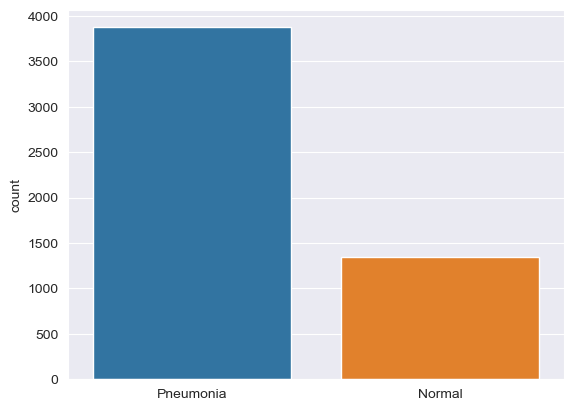

In [6]:
# Data visualization
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style(style='darkgrid')
sns.countplot(x=l)
plt.show()


In [7]:
# Data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)

datagen.fit(x_train)

In [8]:
# Defining the Model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

model.summary()

C:\Users\vikne\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73984)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     4,735,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,790,914 (18.28 MB)

 Trainable params: 4,790,914 (18.28 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Adding learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.000001)

In [10]:
# Training the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=12, validation_data=(x_val, y_val), callbacks=[learning_rate_reduction])

Epoch 1/12


C:\Users\vikne\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
C:\Users\vikne\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 536ms/step - accuracy: 0.7176 - loss: 0.6702 - val_accuracy: 0.5625 - val_loss: 0.7799 - learning_rate: 0.0010
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 499ms/step - accuracy: 0.8396 - loss: 0.3573 - val_accuracy: 0.5625 - val_loss: 0.9969 - learning_rate: 0.0010
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 520ms/step - accuracy: 0.8534 - loss: 0.3352 - val_accuracy: 0.8750 - val_loss: 0.5467 - learning_rate: 0.0010
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 494ms/step - accuracy: 0.8761 - loss: 0.3017 - val_accuracy: 0.8750 - val_loss: 0.5350 - learning_rate: 0.0010
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.8847 - loss: 0.2711
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 72s 437ms/step - accuracy: 0.8848 - loss: 0.2711 - val_accuracy: 0.7500 - val_loss: 0.6818 - learning_rate: 0.0010
Epoch 6/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 648ms/step - accuracy: 0.8954 - loss:

20/20 - 2s - 98ms/step - accuracy: 0.8942 - loss: 0.2678
0.8942307829856873


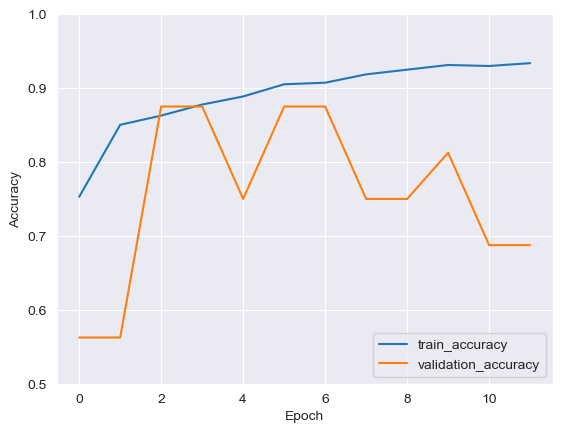

In [17]:
# Ensure x_test and y_test are numpy arrays
x_test = np.array(x_test).reshape(-1, img_size, img_size, 1) / 255.0
y_test = np.array(y_test)

# Testing the model
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='validation_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

print(test_acc)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step
                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.88      0.96      0.92       390
   Normal (Class 1)       0.92      0.78      0.85       234

           accuracy                           0.89       624
          macro avg       0.90      0.87      0.88       624
       weighted avg       0.90      0.89      0.89       624



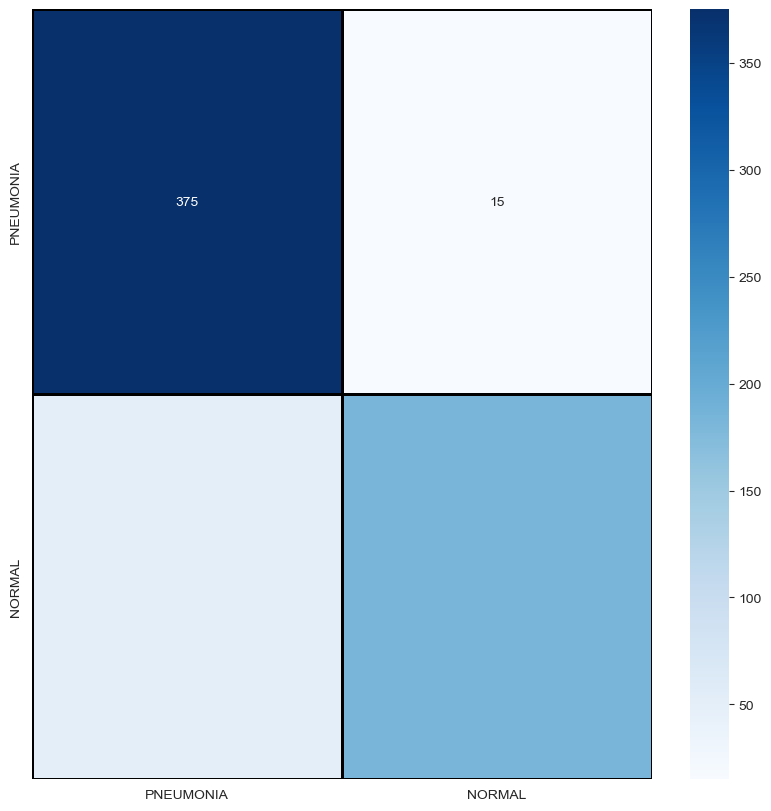

In [12]:
# Creating Confusion Matrix
predictions = np.argmax(model.predict(x_test), axis=-1)

print(classification_report(y_test, predictions, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))

cm = confusion_matrix(y_test, predictions)
cm = pd.DataFrame(cm, index=['0', '1'], columns=['0', '1'])
plt.figure(figsize=(10,10))
sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=labels, yticklabels=labels)
plt.show()